# Imports

In [1]:
import os
import time
import zipfile
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import PIL.Image as pillow # pip install pillow

2025-01-19 12:02:32.068944: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 12:02:32.068995: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 12:02:32.070241: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 12:02:32.169549: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Estrazione del dataset

In [2]:
DATASET_ZIP_PATH="animals.zip"
DATASET_IMGS_DESTDIR="./"

if not os.path.isdir(DATASET_IMGS_DESTDIR + "animals"):
    if not os.path.isfile(DATASET_ZIP_PATH):
        raise FileNotFoundError(f" !! Unable to continue, could not find zipped dataset to extract dataset from: {DATASET_ZIP_PATH}")

    with zipfile.ZipFile(DATASET_ZIP_PATH, mode="r") as animalz:
        animalz.extractall(DATASET_IMGS_DESTDIR)

In [3]:
ws = []
hs = []

start = time.time()

for root, dirs, files in os.walk(DATASET_IMGS_DESTDIR + "animals"):
    path = root.split(os.sep)
    for file in files:
        mypath = f"{DATASET_IMGS_DESTDIR}animals/{os.path.basename(root)}/{file}"
        img = pillow.open(mypath)
        w,h = img.size
        ws.append(w)
        hs.append(h)

avg = lambda n: sum(n) / len(n)

avg_w = int(avg(ws))
avg_h = int(avg(hs))

end = time.time()

print(f"done. it took {end - start:.2f} secs.\navg_w = {avg_w}, avg_h = {avg_h}")

done. it took 27.23 secs.
avg_w = 319, avg_h = 252


# Caricamento del dataset e split

In [4]:
INPUT_SHAPE=(avg_w, avg_w, 3)

training_set, testing_set = keras.utils.image_dataset_from_directory(
    DATASET_IMGS_DESTDIR + "animals",
    subset="both",
    seed=1234,
    validation_split=0.3,
    image_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    label_mode="categorical",
    batch_size=8)

Found 26128 files belonging to 10 classes.
Using 18290 files for training.
Using 7838 files for validation.


2025-01-19 12:03:14.512760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-19 12:03:14.532845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-19 12:03:14.532875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-19 12:03:14.536248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-19 12:03:14.536277: I tensorflow/compile

In [5]:
training_set_size = int(0.8 * len(training_set))
validation_set_size = int(0.2 * len(training_set))
__Training_set = training_set.take(training_set_size)
validation_set = training_set.skip(training_set_size).take(validation_set_size)
training_set = __Training_set

In [6]:
print(f"num of training set batches: {len(training_set)}")
print(f"num of validation set batches: {len(validation_set)}")

num of training set batches: 1829
num of validation set batches: 457


# Costruzione del modello

In [7]:
def build_model(your_base_model):
    top_layers = 0

    def atlay(x):
        nonlocal top_layers
        top_layers += 1
        return x
        
    seq_model = keras.Sequential([
        keras.Input(shape=INPUT_SHAPE),
        keras.layers.Rescaling(scale=1./127.5, offset=-1),
        your_base_model(include_top=False, input_shape=INPUT_SHAPE),
        atlay(keras.layers.GlobalAveragePooling2D()),
        atlay(keras.layers.Dropout(0.25)),
        atlay(keras.layers.Dense(
            10,
            bias_initializer=keras.initializers.GlorotUniform(),
            activation=keras.activations.softmax))
    ])
    
    freezing_layers = seq_model.layers[:len(seq_model.layers) - top_layers]
    for layer in freezing_layers:
        layer.trainable = False

    return (seq_model, top_layers)

In [8]:
(model, model_added_top_layers) = build_model(keras.applications.MobileNet)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 319, 319, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 10, 10, 1024)      3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 3239114 (12.36 MB)
Trainable params: 10250

# Addestramento del modello

## Transfer learning

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy()
    ])

transfer_history = model.fit(
    training_set,
    validation_data=validation_set,
    validation_freq=3,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(
            start_from_epoch=3,
            patience=5,
            restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(
            lambda e, l: l if e < 1 else l * np.exp(-0.15)
        )])

val_loss, val_categorical_accuracy = model.evaluate(validation_set)

Epoch 1/50


2025-01-19 12:03:18.132804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


   1/1829 [..............................] - ETA: 1:12:03 - loss: 3.9299 - categorical_accuracy: 0.0000e+00

2025-01-19 12:03:19.033297: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x149aeba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-19 12:03:19.033338: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-01-19 12:03:19.040692: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-19 12:03:19.126976: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1829/1829 [==============================] - 30s 15ms/step - loss: 0.3570 - categorical_accuracy: 0.8924 - lr: 0.0010
Epoch 2/50
1829/1829 [==============================] - 27s 15ms/step - loss: 0.1588 - categorical_accuracy: 0.9491 - lr: 8.6071e-04
Epoch 3/50
1829/1829 [==============================] - 42s 23ms/step - loss: 0.1251 - categorical_accuracy: 0.9594 - val_loss: 0.1560 - val_categorical_accuracy: 0.9513 - lr: 7.4082e-04
Epoch 4/50
1829/1829 [==============================] - 27s 15ms/step - loss: 0.1156 - categorical_accuracy: 0.9630 - lr: 6.3763e-04
Epoch 5/50
1829/1829 [==============================] - 27s 15ms/step - loss: 0.1035 - categorical_accuracy: 0.9656 - lr: 5.4881e-04
Epoch 6/50
1829/1829 [==============================] - 42s 23ms/step - loss: 0.1007 - categorical_accuracy: 0.9678 - val_loss: 0.1197 - val_categorical_accuracy: 0.9653 - lr: 4.7237e-04
Epoch 7/50
1829/1829 [==============================] - 27s 15ms/step - loss: 0.0927 - categorical_accuracy: 

## Salvataggio pesi correnti

In [12]:
print(f"saving model ({model.layers[1].name}) weights with val_loss = {val_loss:.4f}, val_categorical_accuracy = {val_categorical_accuracy:.4f}")
weights_filename=f"./{model.layers[1].name}_tl_noqnt_noft.ckpt"
model.save_weights(weights_filename)
print(f"done: {weights_filename}")

saving model (mobilenet_1.00_224) weights with val_loss = 0.1065, val_categorical_accuracy = 0.9707
done: ./mobilenet_1.00_224_tl_noqnt_noft.ckpt


# Provare a fare predizioni

1/1 [==============================] - 0s 18ms/step


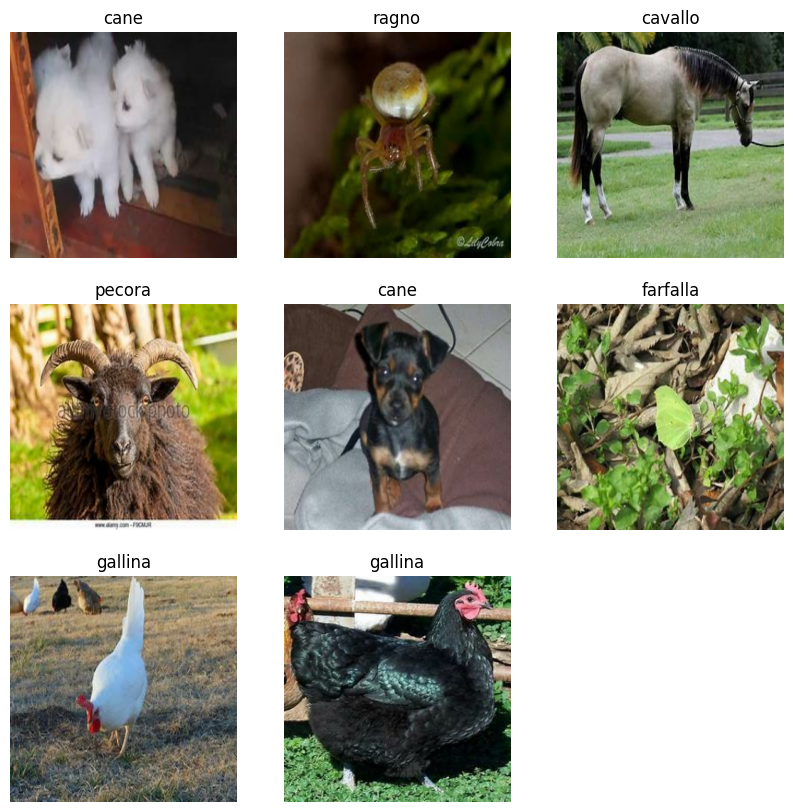

In [17]:
def predict_3x3_from_dataset(dataset, m):
    d = {
        0 : "cane",
        1 : "cavallo",
        2 : "elefante",
        3 : "farfalla",
        4 : "gallina",
        5 : "gatto",
        6 : "mucca",
        7 : "pecora",
        8 : "ragno",
        9 : "scoiattolo"
    }

    shuffled_dataset = dataset.take(1).shuffle(buffer_size=1000)
    plt.figure(figsize=(10, 10))
    for images, labels in shuffled_dataset:
      for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        resized = tf.image.resize([images[i]], (INPUT_SHAPE[0], INPUT_SHAPE[1]))
        inputs = tf.reshape(resized, (1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
        y = m.predict(inputs)
        plt.title(d[np.argmax(y)])
        plt.axis("off")

predict_3x3_from_dataset(validation_set, model)